In [3]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Authenticate to Earth Engine
#ee.Authenticate()
ee.Initialize()

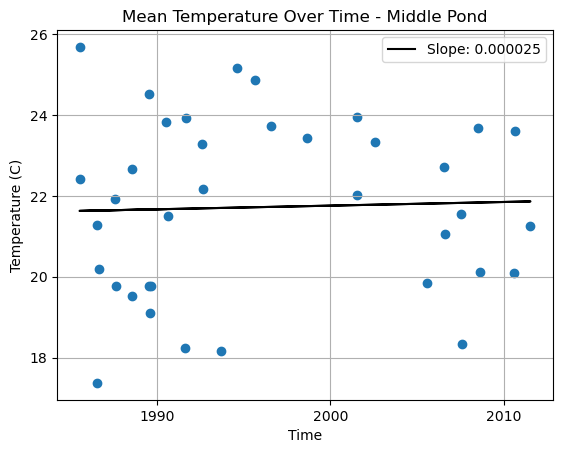

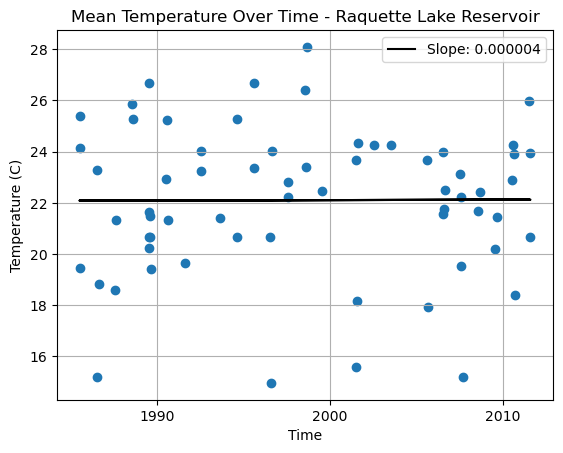

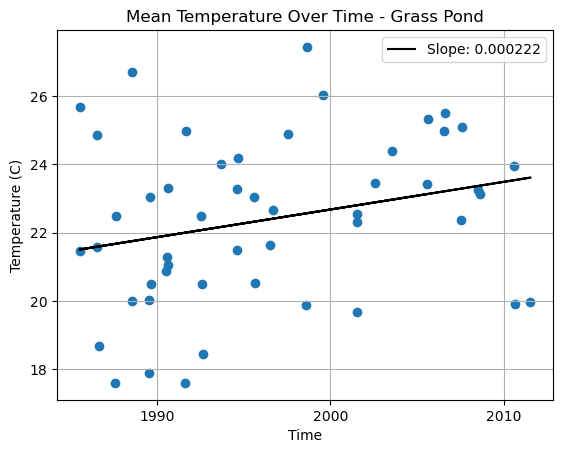

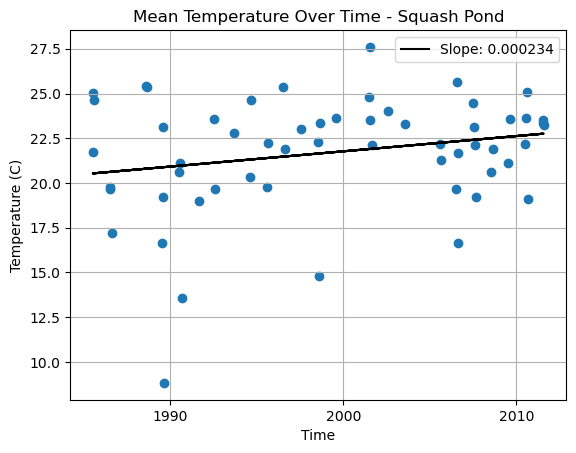

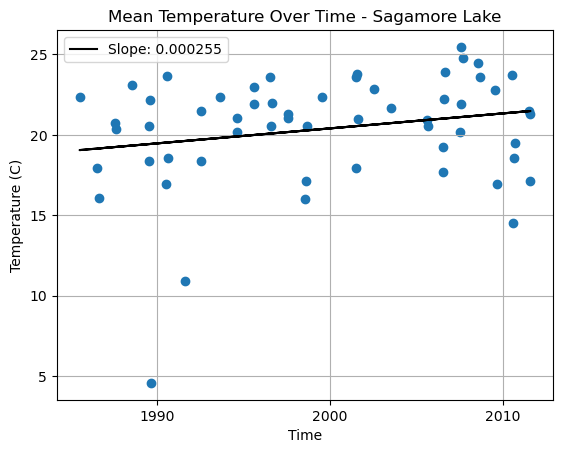

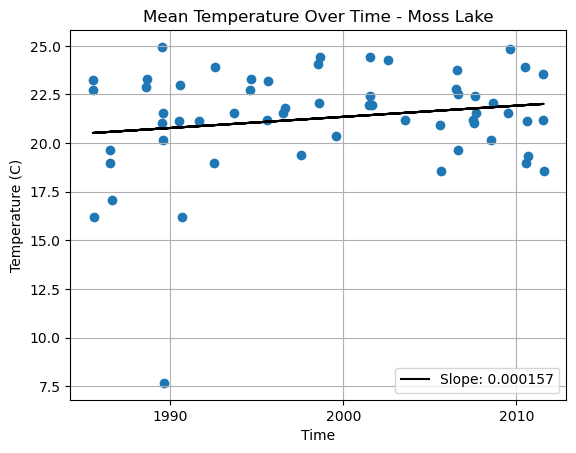

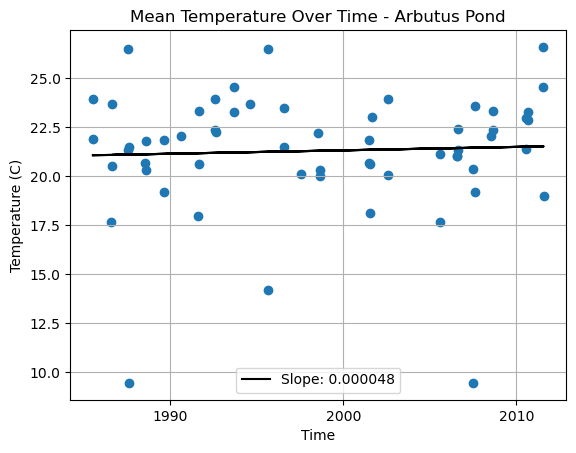

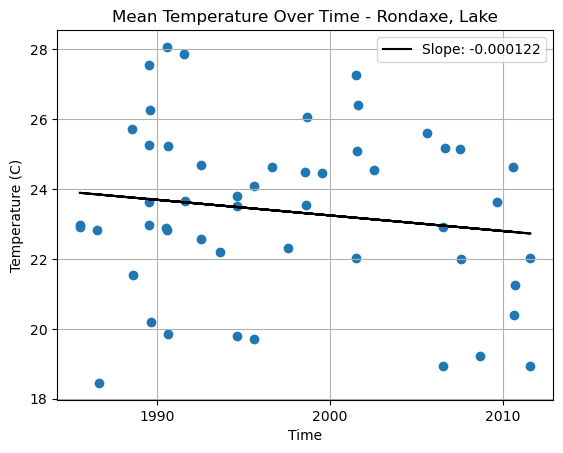

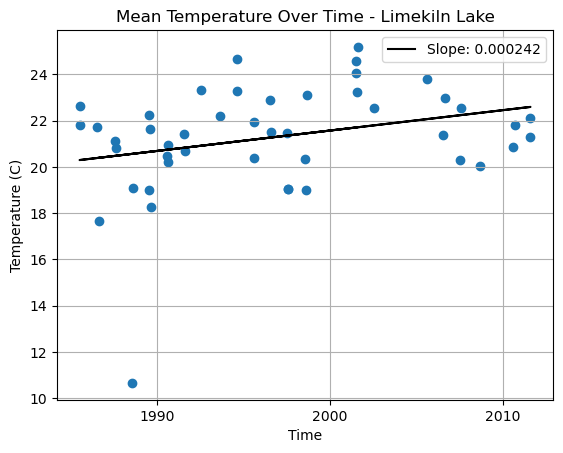

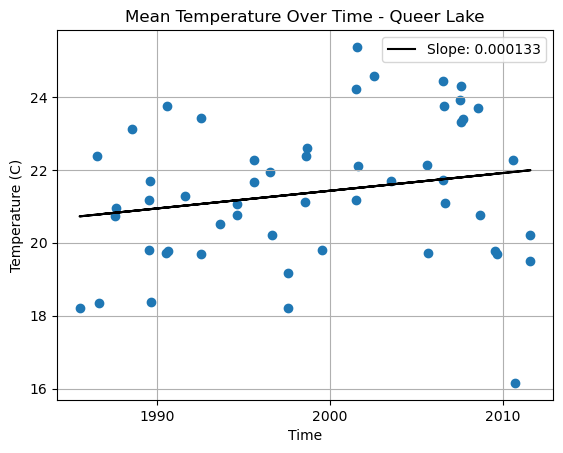

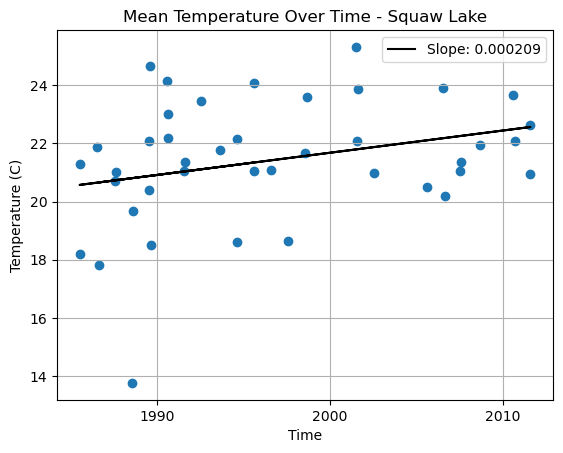

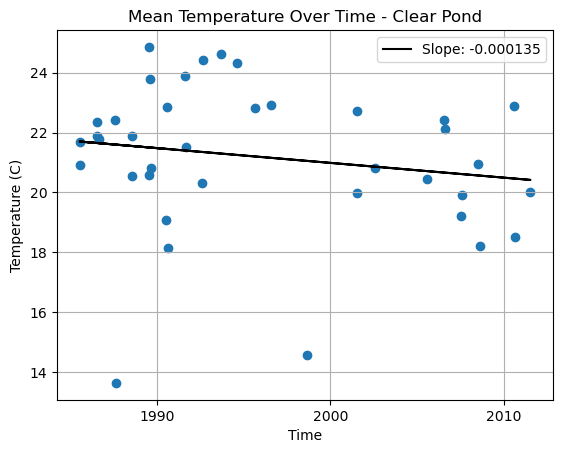

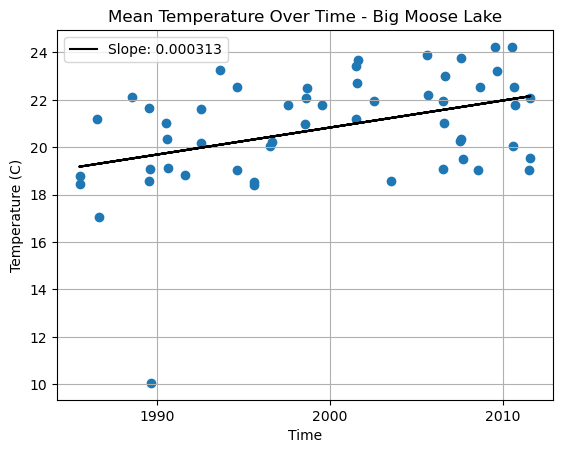

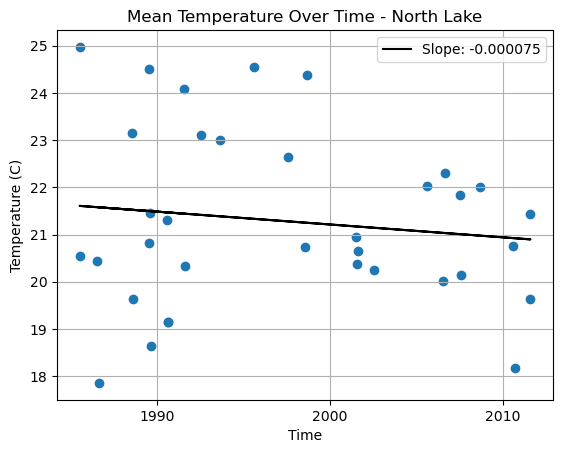

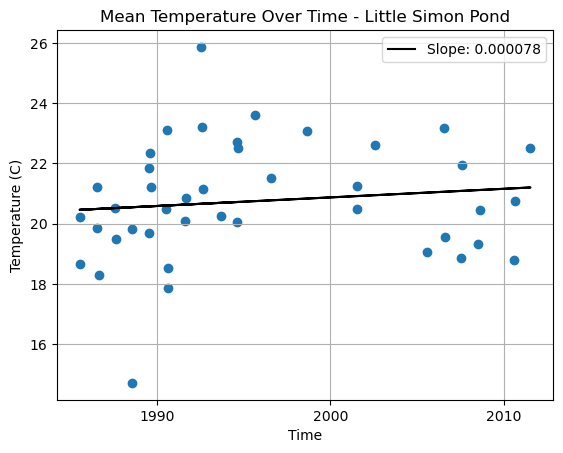

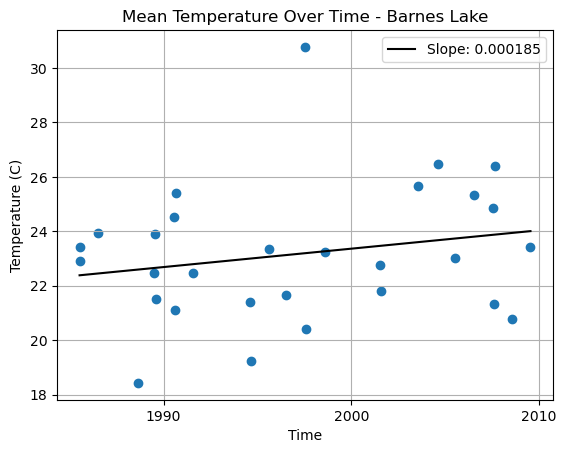

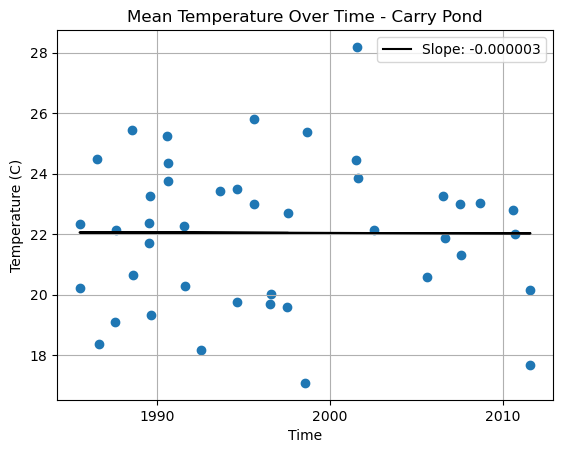

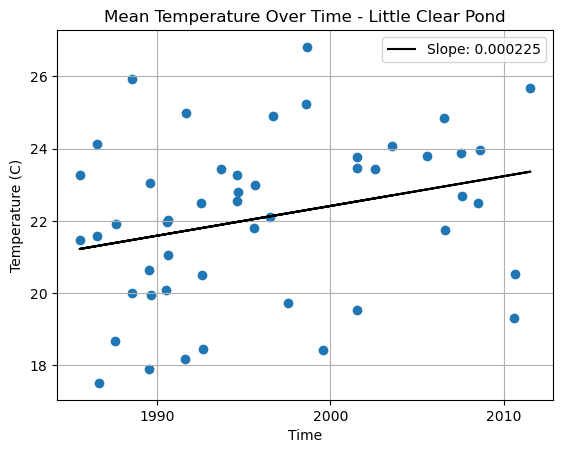

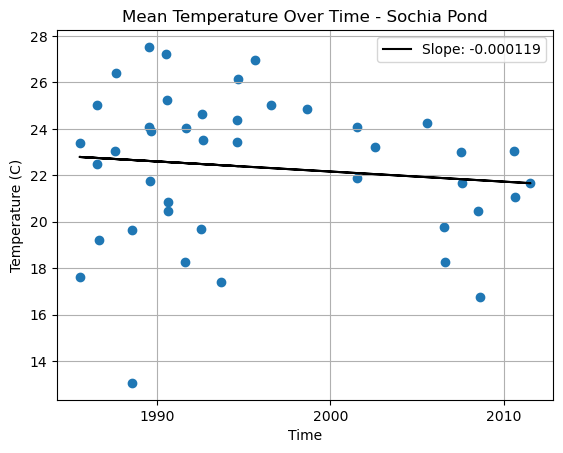

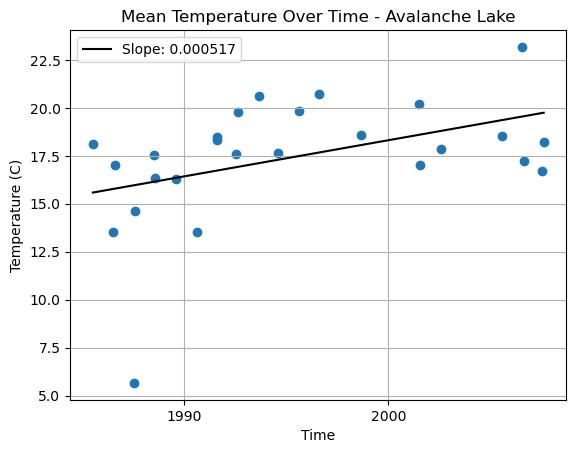

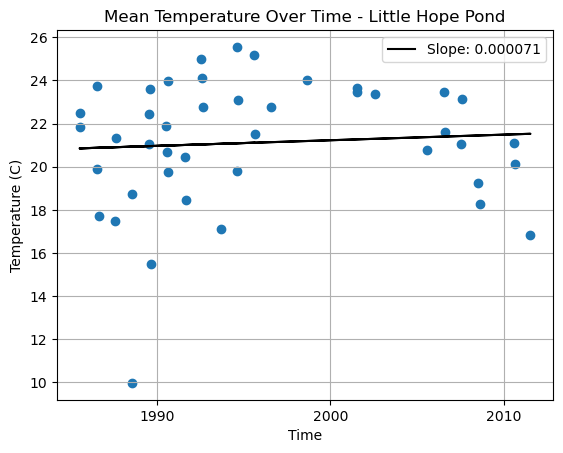

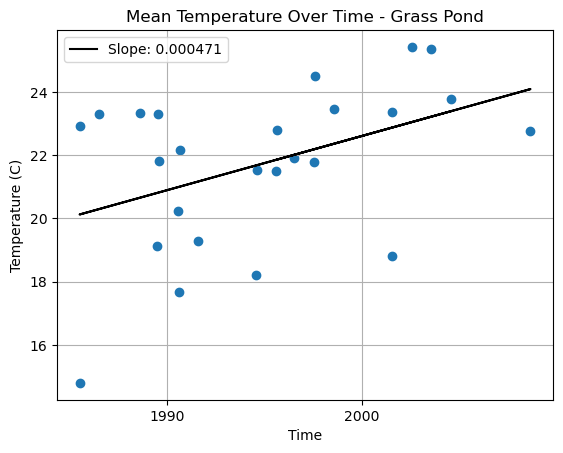

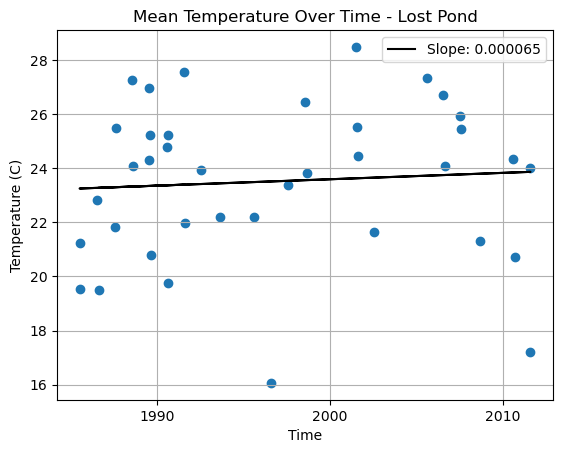

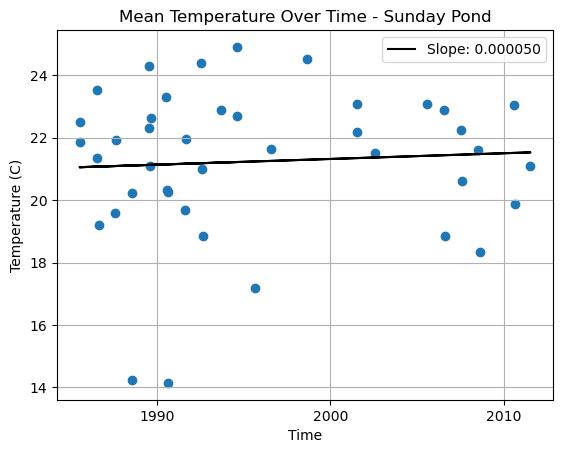

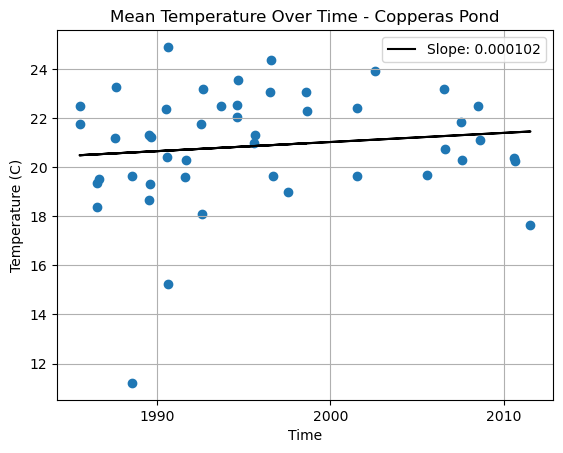

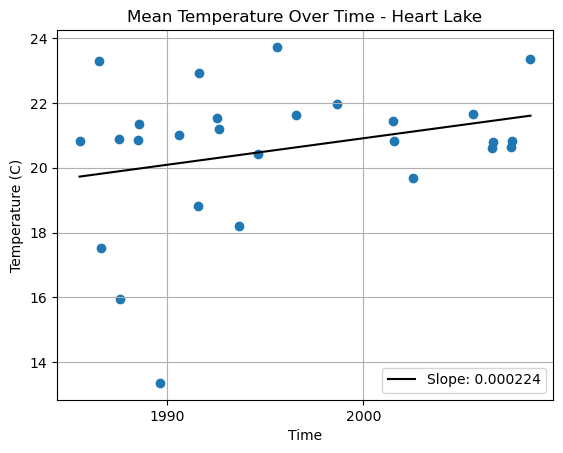

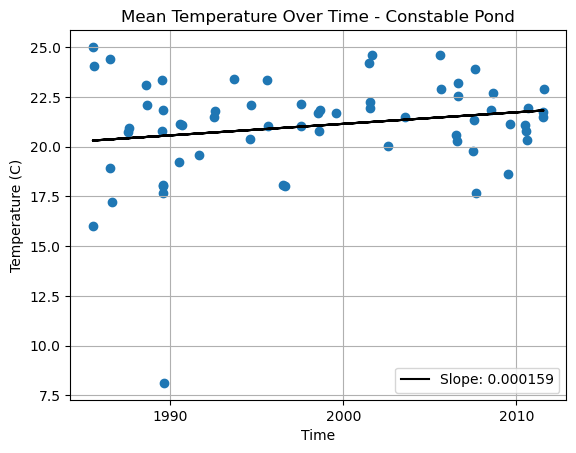

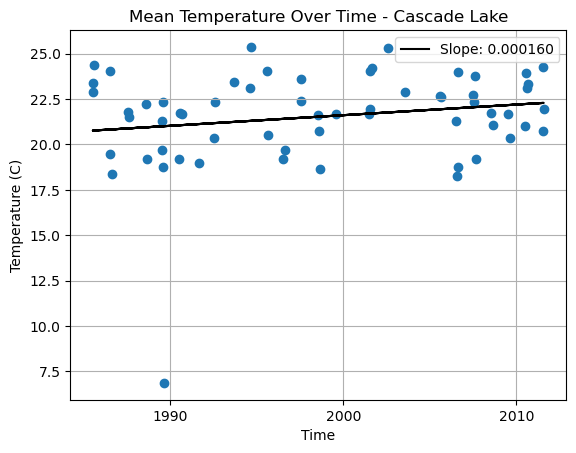

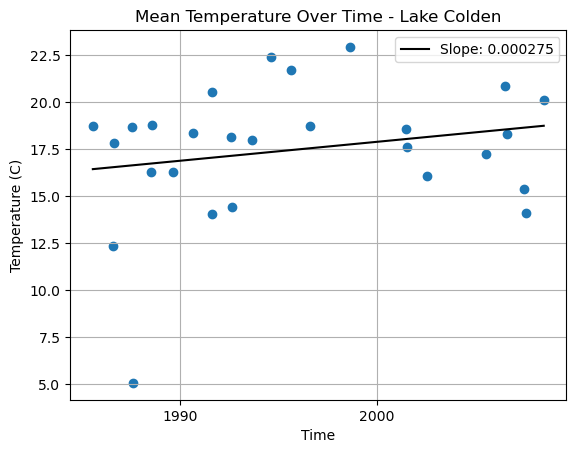

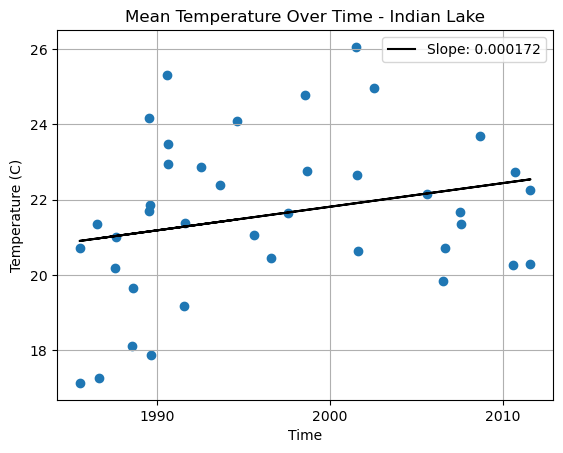

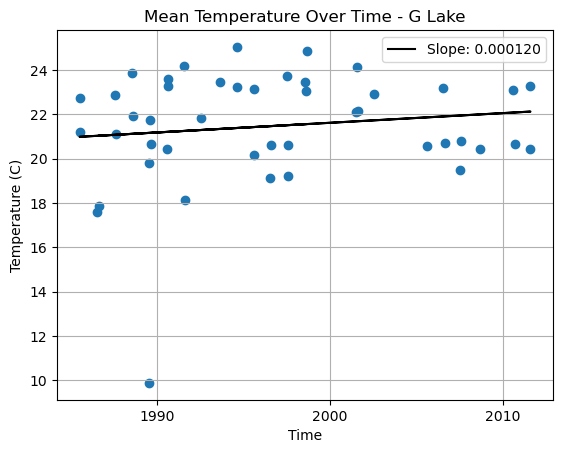

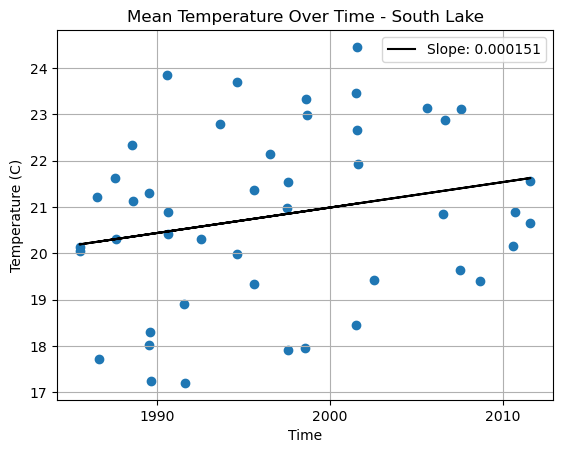

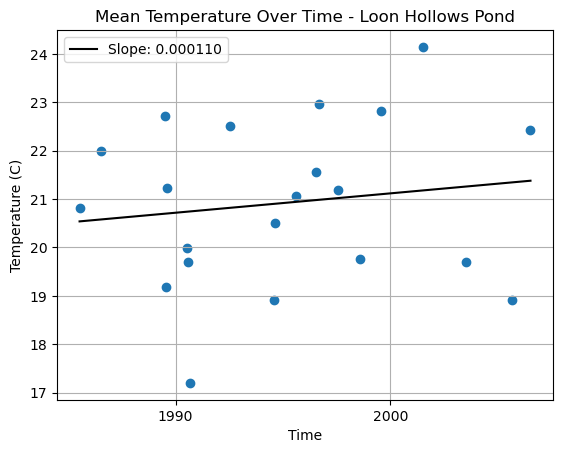

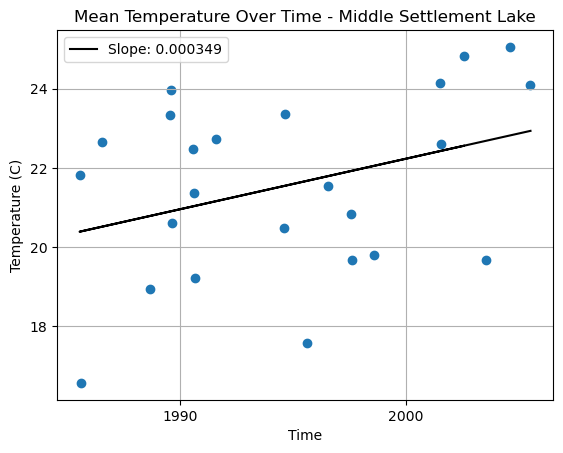

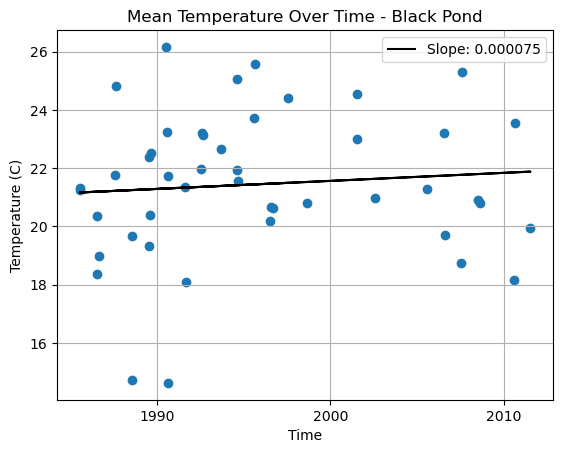

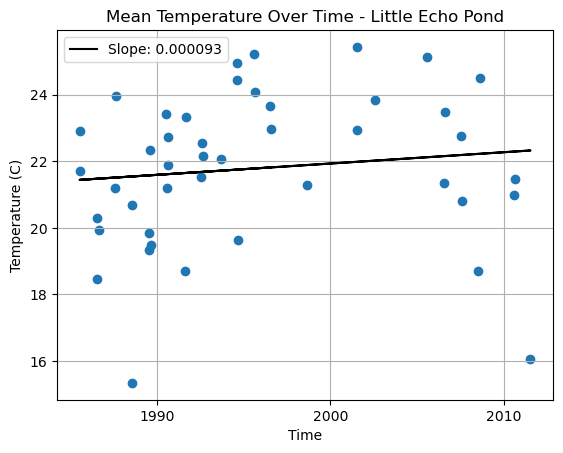

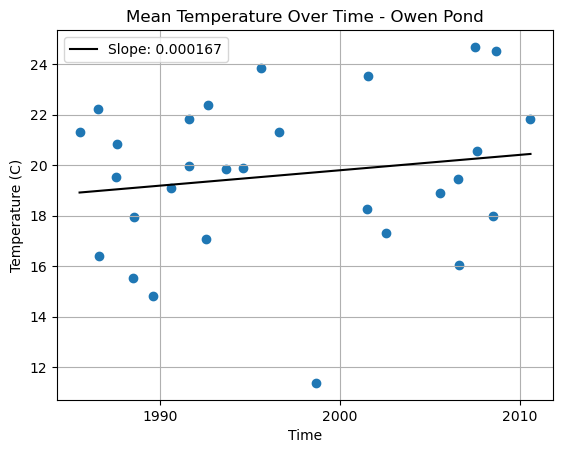

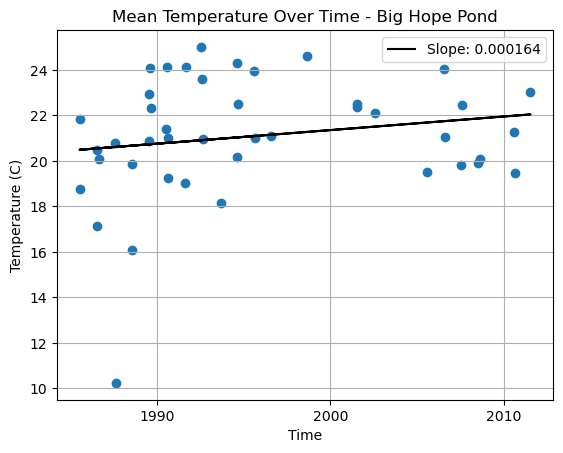

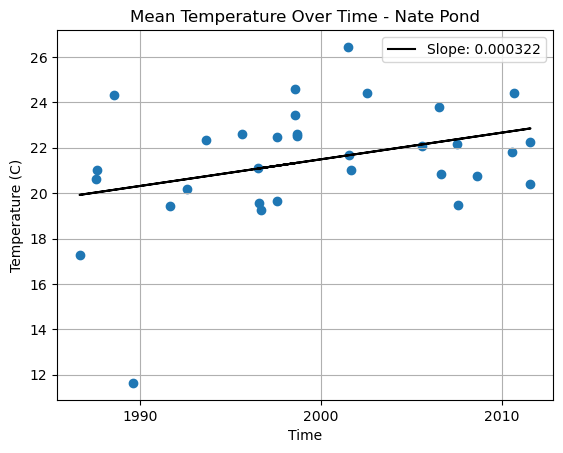

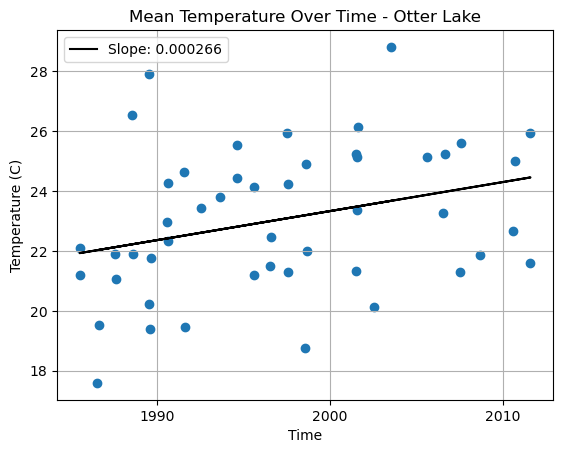

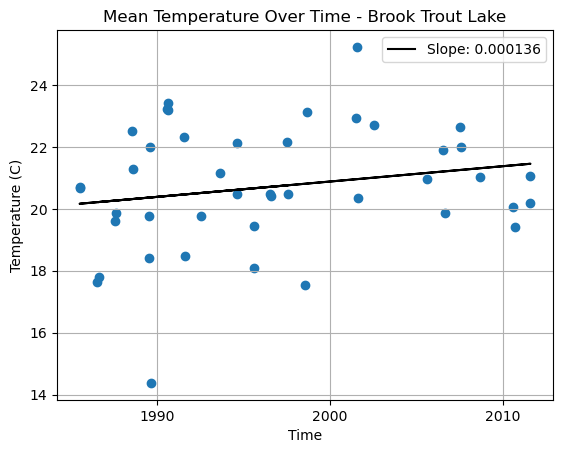

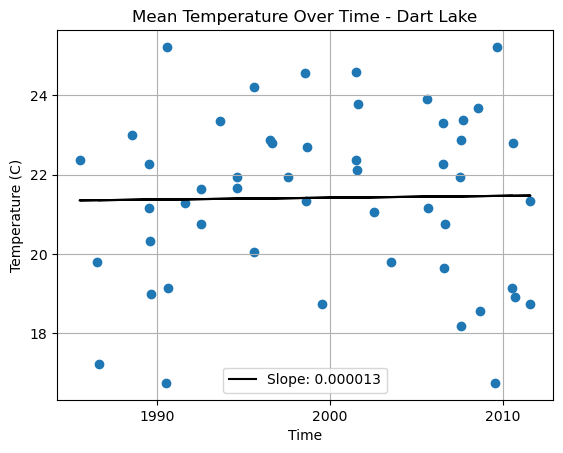

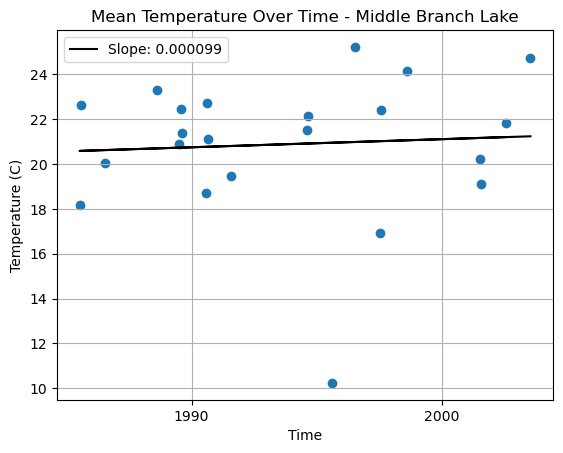

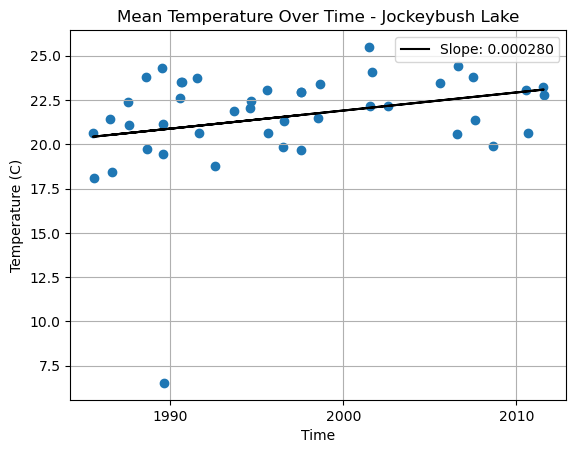

In [77]:
import ee
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
import numpy as np

# Initialize the Earth Engine library
ee.Initialize()

# Define the region of interest (ROI)
all_lakes = (ee.FeatureCollection('projects/ee-mazarderakhsh/assets/ALAP-ALTM-195-centroids')
             .filter(ee.Filter.gt('Field1', 149))
             .filter(ee.Filter.lt('Field1', 195)))  # pick only ALTM lakes

# Convert the lakes FeatureCollection to a List
lakesList = all_lakes.toList(all_lakes.size())

# Function to mask clouds and shadows for Landsat 5
def maskL5(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    mask = image.select('QA_PIXEL').eq(5504).Or(image.select('QA_PIXEL').eq(5440))
    
    opticalBands = image.select('SR_B.')
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(-124.15)
    
    return image.addBands(opticalBands, None, True) \
                .addBands(thermalBand, None, True) \
                .updateMask(qaMask) \
                .updateMask(saturationMask) \
                .updateMask(mask) \
                .clip(all_lakes)

# Loop over each lake in the list
for i in range(lakesList.size().getInfo()):
    lake = ee.Feature(lakesList.get(i))
    lakeName = lake.get('NAME')
    lat = ee.Number(lake.geometry().coordinates().get(1))
    lon = ee.Number(lake.geometry().coordinates().get(0))
    roi = ee.Geometry.Point([lon, lat]).buffer(100)

    # Choose the Landsat data for Landsat 5
    collectionL5 = (ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
                    .filterBounds(roi)
                    .filter(ee.Filter.calendarRange(7, 8, 'month'))
                    .filter(ee.Filter.calendarRange(1985, 2022, 'year'))
                    .filter(ee.Filter.lt('CLOUD_COVER', 25))
                    .map(maskL5))  # Apply Landsat 5 masking function

    # Function to add timestamp as property
    def addTimestamp(image):
        timestamp_band = image.metadata('system:time_start').divide(1000)
        return image.addBands(timestamp_band)

    # Map the function over the collection
    collectionL5 = collectionL5.map(addTimestamp)

    # Function to calculate mean temperature using reduceRegion
    def calculateMeanTemperature(image):
        temperature = image.select(['ST_B6']).reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=30
        )
        timestamp = image.get('system:time_start')
        return ee.Feature(ee.Geometry.Point([lon, lat]), {'temperature': temperature.get('ST_B6'), 'timestamp': timestamp})

    # Map the function over the collection
    temperatureList = collectionL5.map(calculateMeanTemperature)

    # Extract temperature values and timestamps from the result
    temperatureValues = temperatureList.aggregate_array('temperature').getInfo()
    timestamps = temperatureList.aggregate_array('timestamp').getInfo()

    # Convert timestamps to datetime objects
    date_objects = [datetime.utcfromtimestamp(timestamp / 1000) for timestamp in timestamps]

    # Ensure that both lists have the same length
    min_length = min(len(date_objects), len(temperatureValues))
    date_objects = date_objects[:min_length]
    temperatureValues = temperatureValues[:min_length]

    # Linear regression using numpy
    x_values = mdates.date2num(date_objects)
    slope, intercept = np.polyfit(x_values, temperatureValues, 1)

    # Generate a time series plot
    plt.scatter(date_objects, temperatureValues, marker='o')
    plt.plot(date_objects, slope * x_values + intercept, color='black', label=f'Slope: {slope:.6f}')
    plt.xlabel('Time')
    plt.ylabel('Temperature (C)')
    plt.title('Mean Temperature Over Time - {}'.format(lakeName.getInfo()))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(10))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.legend()
    plt.grid(True)
    plt.show()


In [86]:
import ee
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
import numpy as np
from scipy.stats import linregress

# Initialize the Earth Engine library
ee.Initialize()

# Define the region of interest (ROI)
all_lakes = (ee.FeatureCollection('projects/ee-mazarderakhsh/assets/ALAP-ALTM-195-centroids')
             .filter(ee.Filter.gt('Field1', 149))
             .filter(ee.Filter.lt('Field1', 195)))  # pick only ALTM lakes

# Convert the lakes FeatureCollection to a List
lakesList = all_lakes.toList(all_lakes.size())

# Function to mask clouds and shadows for Landsat 5
def maskL5(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    mask = image.select('QA_PIXEL').eq(5504).Or(image.select('QA_PIXEL').eq(5440))
    
    opticalBands = image.select('SR_B.')
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(-124.15)
    
    return image.addBands(opticalBands, None, True) \
                .addBands(thermalBand, None, True) \
                .updateMask(qaMask) \
                .updateMask(saturationMask) \
                .updateMask(mask) \
                .clip(all_lakes)

# Function to calculate mean temperature using reduceRegion
def calculateMeanTemperature(image):
    temperature = image.select(['ST_B6']).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=30
    )
    timestamp = image.get('system:time_start')
    return ee.Feature(ee.Geometry.Point([lon, lat]), {'temperature': temperature.get('ST_B6'), 'timestamp': timestamp})

# Loop over each lake in the list
for i in range(lakesList.size().getInfo()):
    lake = ee.Feature(lakesList.get(i))
    lakeName = lake.get('NAME')
    lat = ee.Number(lake.geometry().coordinates().get(1))
    lon = ee.Number(lake.geometry().coordinates().get(0))
    roi = ee.Geometry.Point([lon, lat]).buffer(100)

    # Choose the Landsat data for Landsat 5
    collectionL5 = (ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
                    .filterBounds(roi)
                    .filter(ee.Filter.calendarRange(7, 8, 'month'))
                    .filter(ee.Filter.calendarRange(1985, 2022, 'year'))
                    .filter(ee.Filter.lt('CLOUD_COVER', 25))
                    .map(maskL5))  # Apply Landsat 5 masking function

    # Function to add timestamp as property
    def addTimestamp(image):
        timestamp_band = image.metadata('system:time_start').divide(1000)
        return image.addBands(timestamp_band)

    # Map the function over the collection
    collectionL5 = collectionL5.map(addTimestamp)

    # Map the function over the collection
    temperatureList = collectionL5.map(calculateMeanTemperature)

    # Extract temperature values and timestamps from the result
    temperatureValues = temperatureList.aggregate_array('temperature').getInfo()
    timestamps = temperatureList.aggregate_array('timestamp').getInfo()

    # Convert timestamps to datetime objects
    date_objects = [datetime.utcfromtimestamp(timestamp / 1000) for timestamp in timestamps]

    # Ensure that both lists have the same length
    min_length = min(len(date_objects), len(temperatureValues))
    date_objects = date_objects[:min_length]
    temperatureValues = temperatureValues[:min_length]

    # Check the significance of each data point using scipy.stats.linregress
    significant_indices = []
    for i in range(len(date_objects)):
        x_values = mdates.date2num([date_objects[i]])
        slope, _, _, p_value, _ = linregress(x_values, [temperatureValues[i]])

        # Check if the p-value is less than 0.05
        if p_value < 0.2:
            significant_indices.append(i)

    # Check if there are any significant points
    if not significant_indices:
        print(f"No significant points for {lakeName.getInfo()}")
        continue

    # Remove insignificant points
    date_objects_significant = [date_objects[idx] for idx in significant_indices]
    temperatureValues_significant = [temperatureValues[idx] for idx in significant_indices]

    # Linear regression using scipy.stats.linregress on significant points
    x_values_significant = mdates.date2num(date_objects_significant)
    slope_significant, intercept, _, _, _ = linregress(x_values_significant, temperatureValues_significant)

    # Generate a time series plot for significant points
    plt.scatter(date_objects_significant, temperatureValues_significant, marker='o')
    plt.plot(date_objects_significant, slope_significant * x_values_significant + intercept, color='black',
             label=f'Slope: {slope_significant:.6f}')
    plt.xlabel('Time')
    plt.ylabel('Temperature (C)')
    plt.title('Mean Temperature Over Time - {}'.format(lakeName.getInfo()))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(10))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.legend()
    plt.grid(True)
    plt.show()


No significant points for Middle Pond
No significant points for Raquette Lake Reservoir
No significant points for Grass Pond
No significant points for Squash Pond
No significant points for Sagamore Lake
No significant points for Moss Lake
No significant points for Arbutus Pond
No significant points for Rondaxe, Lake
No significant points for Limekiln Lake
No significant points for Queer Lake
No significant points for Squaw Lake
No significant points for Clear Pond
No significant points for Big Moose Lake
No significant points for North Lake
No significant points for Little Simon Pond
No significant points for Barnes Lake
No significant points for Carry Pond
No significant points for Little Clear Pond
No significant points for Sochia Pond
No significant points for Avalanche Lake
No significant points for Little Hope Pond
No significant points for Grass Pond
No significant points for Lost Pond
No significant points for Sunday Pond
No significant points for Copperas Pond
No significant po